In [1]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("obsSSRG_nadir.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwc_CS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]
    
pnorm=np.log10(1e-3*(pnorm))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)*0.5
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(zKu)
zKuPC=pca.transform(zKu)
print(zKuPC.shape)
#stop
bscatter=pnorm[:,30:45]
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    z1[z1<8]=0
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
yobsLidarL=np.concatenate((yobsL,np.array(lidarEchoPeak)[:,:],pnorm),axis=-1)
yobsLidarLR=yobsL
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape
X_train=yobsL[ind_train,:]
X_test=yobsL[ind_test,:]
XLidar_train=yobsLidarL[ind_train,:]
XLidar_test=yobsLidarL[ind_test,:]
XLidarR_train=yobsLidarLR[ind_train,:]
XLidarR_test=yobsLidarLR[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]
iwc_CS_test=iwc_CS[ind_test,:]
zKu_train=zKu[ind_train,:]
zKu_test=zKu[ind_test,:]



/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_25350/4043045561.py:14: RuntimeWarning: divide by zero encountered in log10
  pnorm=np.log10(1e-3*(pnorm))
/Users/mgrecu/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


(138606, 5)


In [83]:
print(XLidar_train.shape)

(92866, 21)


In [2]:
nC=18
from sklearn.cluster import KMeans
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)
#define tensorflow classifier in keras. use 2 hidden layers and nc=12 output classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import utils

# define the model
X1_train=XLidarR_train[:,:]
X1_test=XLidarR_test[:,:]
def get_model(nC):
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[X1_train.shape[1]]),
        layers.Dense(30, activation='relu'),
        layers.Dense(nC, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model


model=get_model(nC)
print(model.summary())
# convert to one-hot encoding
y_train_onehot=utils.to_categorical(kmeans_iwc.labels_)
y_test_onehot=utils.to_categorical(kmeans_iwc.predict(iwc_test))
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X_train_scaled=scaler.transform(X1_train)
X_test_scaled=scaler.transform(X1_test)

print(X_train_scaled.shape)
print(X_test_scaled.mean(axis=0))
print(y_train_onehot.shape)
# train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_test_scaled, y_test_onehot),
    batch_size=32,
    epochs=20,
    verbose=1)

model.save("modelRadiometerClass.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                150       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 18)                558       
                                                                 
Total params: 1,638
Trainable params: 1,638
Non-trainable params: 0
_________________________________________________________________
None
(92866, 4)
[-0.00920784 -0.01287311 -0.02082252  0.00543189]
(92866, 18)
Epoch 1/20


2023-01-26 10:10:19.824392: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2903/2903 [==============================] - 2s 600us/step - loss: 1.8074 - accuracy: 0.3848 - val_loss: 1.7410 - val_accuracy: 0.3907
Epoch 2/20
2903/2903 [==============================] - 2s 564us/step - loss: 1.7338 - accuracy: 0.3942 - val_loss: 1.7342 - val_accuracy: 0.3933
Epoch 3/20
2903/2903 [==============================] - 2s 591us/step - loss: 1.7291 - accuracy: 0.3948 - val_loss: 1.7309 - val_accuracy: 0.3948
Epoch 4/20
2903/2903 [==============================] - 2s 596us/step - loss: 1.7271 - accuracy: 0.3961 - val_loss: 1.7312 - val_accuracy: 0.3961
Epoch 5/20
2903/2903 [==============================] - 2s 593us/step - loss: 1.7254 - accuracy: 0.3967 - val_loss: 1.7329 - val_accuracy: 0.3951
Epoch 6/20
2903/2903 [==============================] - 2s 568us/step - loss: 1.7242 - accuracy: 0.3974 - val_loss: 1.7261 - val_accuracy: 0.3974
Epoch 7/20
2903/2903 [==============================] - 2s 568us/step - loss: 1.7235 - accuracy: 0.3964 - val_loss: 1.7278 - val_accura

In [12]:
def get_modelIWP(nout):
    model = keras.Sequential([
        layers.Dense(50, activation='relu', input_shape=[X1_train.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(nout, activation=None)
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanSquaredError()])
    return model
modelIWP_LR=get_modelIWP(1)
scalerIWP = StandardScaler()

iwp_train_scaled=scalerIWP.fit_transform((iwc_train.sum(axis=-1))[:,np.newaxis]*0.24)
iwp_test_scaled=scalerIWP.transform((iwc_test.sum(axis=-1))[:,np.newaxis]*0.24)

history = modelIWP_LR.fit(
    X_train_scaled, iwp_train_scaled[:,np.newaxis],
    validation_data=(X_test_scaled, iwp_test_scaled[:,np.newaxis]),
    batch_size=32,
    epochs=20,
    verbose=1)

modelIWP_LR.save("modelLidarRadar_IWP.h5")

Epoch 1/20
2903/2903 [==============================] - 2s 675us/step - loss: 0.1890 - mean_squared_error: 0.1890 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 2/20
2903/2903 [==============================] - 2s 641us/step - loss: 0.1042 - mean_squared_error: 0.1042 - val_loss: 0.0779 - val_mean_squared_error: 0.0779
Epoch 3/20
2903/2903 [==============================] - 2s 634us/step - loss: 0.0857 - mean_squared_error: 0.0857 - val_loss: 0.0568 - val_mean_squared_error: 0.0568
Epoch 4/20
2903/2903 [==============================] - 2s 632us/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 5/20
2903/2903 [==============================] - 2s 633us/step - loss: 0.0779 - mean_squared_error: 0.0779 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
Epoch 6/20
2903/2903 [==============================] - 2s 637us/step - loss: 0.0742 - mean_squared_error: 0.0742 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoc

In [3]:
iwpC=[]
kgainL=[]
nx=X_train_scaled.shape[1]
xmL=[]
for i in range(nC):
    iwpC.append(kmeans_iwc.cluster_centers_[i,:].sum()*0.24)
    a=np.nonzero(kmeans_iwc.labels_==i)
    xk=X_train_scaled[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.05*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.inv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xmL.append(np.mean(xk,axis=0))

print(iwpC)

[0.08180295758865695, 0.9089434414931393, 1.6821731655012089, 0.480173359889555, 0.9642660480778131, 1.6737403727582874, 0.23640980883686002, 2.0027355312757034, 0.5528023181453682, 0.21693116711461696, 0.5190242172609898, 0.24195421165332084, 1.150682836030796, 3.090464643169096, 0.18547591360809249, 0.9074943865117198, 0.6241187462041995, 1.809282271247035]


In [33]:
print(covXY.shape)
print(kgainL[0].shape)

(156, 156)
(50, 106)


1430/1430 [==============================] - 0s 289us/step


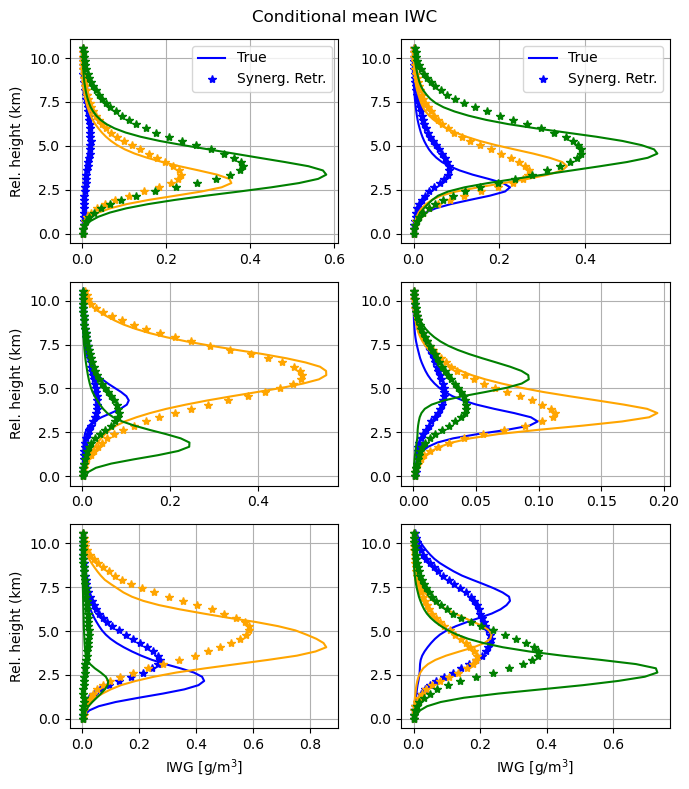

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']

class_onehot_=model.predict(X_test_scaled)
iwcLR_=[]
for i,iwp1_ in enumerate(X_test_scaled):
    iclass=np.argmax(class_onehot_[i,:])
    iwc1=kmeans_iwc.cluster_centers_[iclass,:]+0.975*np.dot(kgainL[iclass],X_test_scaled[i,:]-xmL[iclass])
    iwcLR_.append(iwc1)
iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Synerg. Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('iwcRetrievedClassesSSRGRadiometer.png')

(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_25350/909145776.py:13: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.         0.55397299]
 [0.55397299 1.        ]]


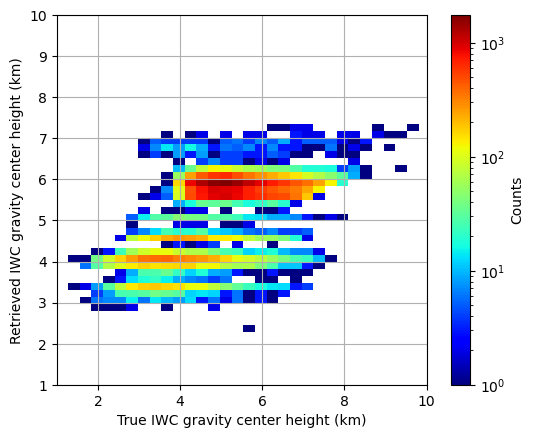

In [5]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    h=np.arange(50)
    a1=np.nonzero(iwc1>0.01)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    if len(a1[0])>3:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=30,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
cbar.set_label('Counts')
plt.savefig('radiometer_iwcGcHeight.png')
print(np.corrcoef(hgRealL,hgPredL))

0.3120469905059262 0.3121483114525631


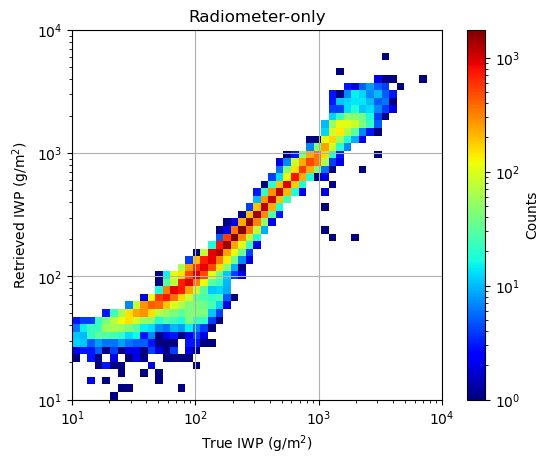

In [15]:
iwcLR_=np.array(iwcLR_)
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)
#plt.figure(figsize=(6,6))
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwpLR_*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radiometer-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('radiometerLidarRadar_iwpRetrieval_nadir.png')
print(np.mean(iwpLR_),np.mean(iwp_test_))

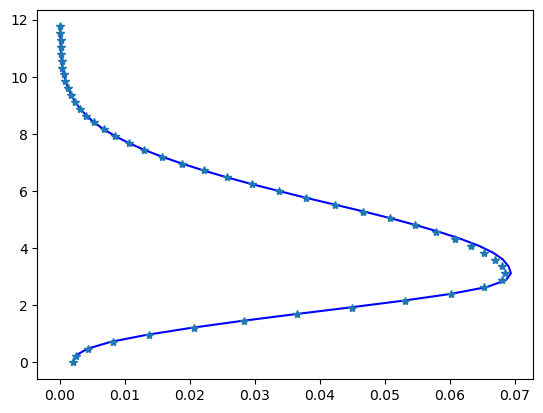

In [54]:
plt.plot(iwc_test.mean(axis=0),np.arange(0,50)*0.24,'b',label='True')
plt.plot(iwcLR_.mean(axis=0),np.arange(0,50)*0.24,'*',label='Retrieved')

In [18]:
print(iwc_.shape)

(92866, 50)
